In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from numpy import mean
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN


In [2]:
# function to display from clipboard images (saves in same local directory as this notebook)..waiting for a days when this is OTB in VSCode
def display_img_from_clipbpard(file_prefix=None):
    from PIL import ImageGrab
    import uuid
    from IPython.display import Markdown, display
    
    img = ImageGrab.grabclipboard()
    unique_id = str(uuid.uuid1())
    
    if file_prefix is not None:
        img_file_name = file_prefix + unique_id + '.png'
    else:
        img_file_name = str(uuid.uuid1()) + '.png'

    try:
        img.save(img_file_name, 'PNG')
        mystring = '***\n' + file_prefix + "\n\n" + "![{0}]({1} '{2}')\n".format(unique_id, img_file_name, unique_id) + "***"
        print(mystring)
        #display(Markdown(mystring))
    except:
        print('Cannot save image in current directory')

In [3]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=1, cluster_std=3)
X

array([[-5.85599836,  4.65179333],
       [-5.83379108, -3.27474928],
       [ 7.43301143,  6.88024374],
       ...,
       [-2.43650847,  4.97436946],
       [-2.06889414,  4.04932731],
       [-9.73360422, -6.17862924]])

In [4]:
# seems balanced for now
print('unique', np.unique(y, return_counts=True))

unique (array([0, 1]), array([500, 500], dtype=int64))


<AxesSubplot:>

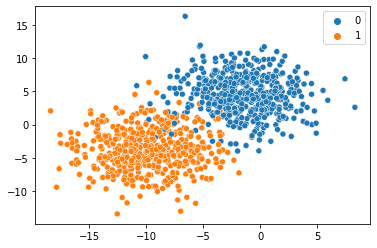

In [5]:
sns.scatterplot(x=X[:,0], y=X[:, 1], hue=y)

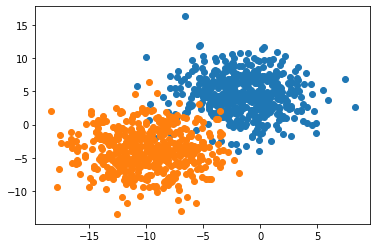

In [6]:
for value in range(2):
    row_idx = np.where(y==value)
    plt.scatter(X[row_idx, 0], X[row_idx, 1])

In [7]:
def get_dataset(proportions):
    n_classes = len(proportions)
    # determine the number of examples to generate for each class
    largest = max([v for k,v in proportions.items()])
    n_samples = largest * n_classes
    # create dataset
    X, y = make_blobs(n_samples=n_samples, centers=n_classes, n_features=2, random_state=1,
    cluster_std=3)
    # collect the examples
    X_list, y_list = list(), list()
    for k,v in proportions.items():
        row_ix = np.where(y == k)[0]
        selected = row_ix[:v]
        X_list.append(X[selected, :])
        y_list.append(y[selected])
    return np.vstack(X_list), np.hstack(y_list)
       
    

In [8]:
def plot_dataset(X, y):
    # create scatter plot for samples from each class
    n_classes = len(np.unique(y))
    for class_value in range(n_classes):
        # get row indexes for samples with this class
        row_ix = list(np.where(y == class_value)[0])
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(class_value))
    
    plt.legend()
    plt.show()

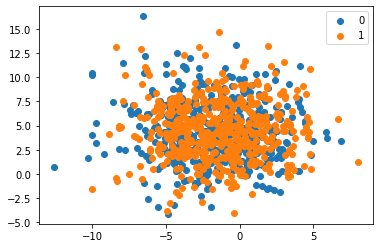

In [9]:
proportions = {0:5000, 1:5000}
X, Y = get_dataset(proportions= proportions)
plot_dataset(X,y)

***
Note that when working with binary classification problems, especially imbalanced problems,
it is important that the majority class is assigned to class 0 and the minority class is assigned
to class 1. This is because many evaluation metrics will assume this relationship. Therefore, we
can ensure our class distributions meet this practice by defining the majority then the minority
classes in the call to the get dataset() function; for example
***

***
### Different Skewed  Distributions
***

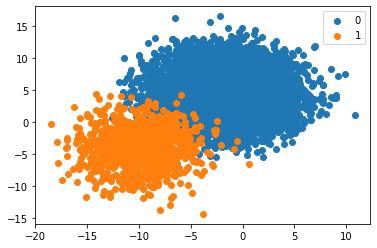

In [10]:
# Skewed distribution

# define the class distribution
proportions = {0:10000, 1:1000}
# generate dataset
X, y = get_dataset(proportions)
# plot dataset
plot_dataset(X, y)



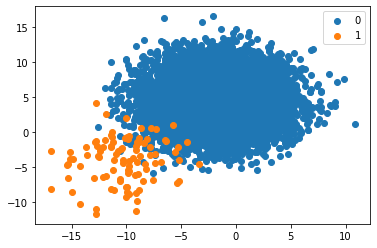

In [11]:
# define the class distribution
proportions = {0:10000, 1:100}
# generate dataset
X, y = get_dataset(proportions)
# plot dataset
plot_dataset(X, y)


***
Because the class distribution is not balanced, most machine learning algorithms will perform
poorly and require modification to avoid simply predicting the majority class in all cases.
Additionally, metrics like classification accuracy lose their meaning and alternate methods for
evaluating predictions on imbalanced examples are required, like ROC area under curve. This is
the foundational challenge of imbalanced classification.
An additional level of complexity comes from the problem domain from which the examples
were drawn. It is common for the majority class to represent a normal case in the domain,
whereas the minority class represents an abnormal case, such as a fault, fraud, outlier, anomaly,
disease state, and so on. As such, the interpretation of misclassification errors may differ across
the classes.

For example, misclassifying an example from the majority class as an example from the
minority class called a false positive is often not desired, but less critical than classifying an
example from the minority class as belonging to the majority class, a so-called false negative.
This is referred to as cost sensitivity of misclassification errors and is a second foundational
challenge of imbalanced classification. Example below confusion matrix tells that 68 samples are false negatives (minority classified as majority).
***

***
Comfusion_matrix_TOxicity

![e60d0114-565d-11ec-bd8a-089798e3c732](Comfusion_matrix_TOxicitye60d0114-565d-11ec-bd8a-089798e3c732.png 'e60d0114-565d-11ec-bd8a-089798e3c732')
***

***
### The data is highly imbalanced and is completely biased with majority of non-toxic.

### Report the accuracy on the train set
>### We have accuracy of 98.05%. Quality of model looks good in predicting overall.
>### However due to huge imbalance in data, this score is largely contributed by TN(majority of non-toxic).
>### Such model can perform poorly on a majority toxic biased data.

### Report the recall(True Positive Rate/ sensitivity) on the train set:decent, high, low?
>### 100% on non-toxic meaning model is able to completely capture non-toxic without any misclassification
>### 78%(238 samples) correcly classified toxic, model misclassified 33% (68 samples) as non-toxic(FN)
>### The Cost Sensitivity of misclassification can be considered high, in that, 68 samples of minority class were classified as majority (False Negative)
>### Since we are interested in rarer event's(toxicity on wiki), we focus on improving on this aspect

### Get the f1_score on the train set
>### 99% on non-toxic so we have a good balance between precision and recall
>### 88% on toxic...we track this in our next steps where we improve on recall which tend to flutuate precision
  
***

***
### Imbalanced Dataset Creation using SKLEARN
***

Size=100, Ratio=Counter({0: 99, 1: 1})
Size=1000, Ratio=Counter({0: 990, 1: 10})
Size=10000, Ratio=Counter({0: 9900, 1: 100})
Size=100000, Ratio=Counter({0: 99000, 1: 1000})


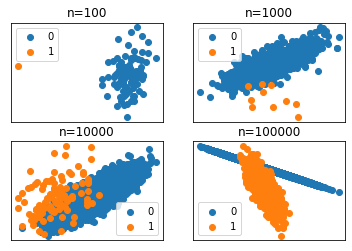

In [12]:
from sklearn.datasets import make_classification
from collections import Counter
# dataset sizes
sizes = [100, 1000, 10000, 100000]
# create and plot a dataset with each size
for i in range(len(sizes)):
    # determine the dataset size
    n = sizes[i]
    # create the dataset
    X, y = make_classification(n_samples=n, n_features=2, n_redundant=0,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
    # summarize class distribution
    counter = Counter(y)
    print('Size=%d, Ratio=%s' % (n, counter))
    # define subplot
    plt.subplot(2, 2, 1+i)
    plt.title('n=%d' % n)
    plt.xticks([])
    plt.yticks([])
    # scatter plot of examples by class label
    for label, _ in counter.items():
        row_ix = np.where(y == label)[0]
        plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
        plt.legend()
        # show the figure

    plt.show

***
### Chapter 14. Binary Test Problem and Decision Tree Model
***

Counter({0: 9900, 1: 100})


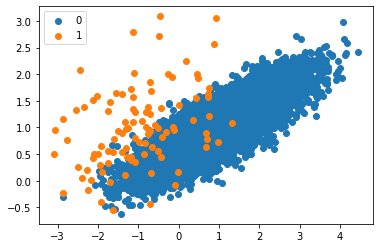

In [17]:
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()


In [23]:

# define model
model = DecisionTreeClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.766


***
###  Random Oversampling and Undersampling
***

In [25]:
# define model
model = DecisionTreeClassifier()
# define sampling
over = RandomOverSampler(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
# define pipeline
pipeline = Pipeline(steps=[('o', over), ('u', under), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))



Mean ROC AUC: 0.816


***
### SMOTE and Random Undersampling
***

In [27]:
# define model
model = DecisionTreeClassifier()
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('m', model)]
pipeline = Pipeline(steps=steps)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.829


***
### SMOTE and Tomek Links Undersampling
***

In [29]:
# define model
model = DecisionTreeClassifier()
# define sampling
resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))


Mean ROC AUC: 0.815


***
###  SMOTE and Edited Nearest Neighbors Undersampling

***

In [45]:
# define model
model = DecisionTreeClassifier()
# define sampling

resample = SMOTEENN()
# define pipeline
pipeline = Pipeline(steps=[('r', resample), ('m', model)])
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
# summarize performance
print('Mean recall: %.3f' % mean(scores))


Mean recall: 0.760
